In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
 import keras
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

Using TensorFlow backend.


In [4]:
import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from helpers import plots, evaluation, utils

### Load model

In [5]:
model = load_model('../models/brats_3ch_model_2.h5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_a (Conv2D)              (None, 240, 240, 16)      448       
_________________________________________________________________
max_a (MaxPooling2D)         (None, 120, 120, 16)      0         
_________________________________________________________________
drop_a (Dropout)             (None, 120, 120, 16)      0         
_________________________________________________________________
conv_b (Conv2D)              (None, 120, 120, 32)      4640      
_________________________________________________________________
max_b (MaxPooling2D)         (None, 60, 60, 32)        0         
_________________________________________________________________
conv_c (Conv2D)              (None, 60, 60, 64)        18496     
_________________________________________________________________
max_c (MaxPooling2D)         (None, 30, 30, 64)        0         
__________

### Load images

In [5]:
train_dir = '../data/train/t2_t1ce_flair'
valid_dir = '../data/valid/t2_t1ce_flair'
valid_seg_dir = '../data/valid/seg_t2_t1ce_flair'
batch_size = 16
IMG_HEIGHT = 240
IMG_WIDTH = 240
SEED=42
train_generator = ImageDataGenerator(rescale=1./255)
val_generator = ImageDataGenerator(rescale=1./255)
seg_generator = ImageDataGenerator(rescale=1./4)

def get_generator(gen, classes=None):
    return gen.flow_from_directory(batch_size=batch_size,
                                            directory=valid_dir,
                                            color_mode="rgb",
                                            shuffle=True,
                                            classes=classes,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            class_mode='binary',
                                             seed = SEED)

def get_seg_generator(gen, classes=None):                                            
    return gen.flow_from_directory(batch_size=batch_size,
                                                directory=valid_seg_dir,
                                                color_mode="grayscale",
                                                shuffle=True,
                                                classes=classes,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary', 
                                                seed = SEED)
val_gen = get_generator(val_generator)
val_seg_gen = get_seg_generator(seg_generator)

Found 3360 images belonging to 2 classes.
Found 3360 images belonging to 2 classes.


In [8]:
x, y = next(val_gen)
x_seg, y_seg = next(val_seg_gen)

[1. 1. 1. 1. 0.]


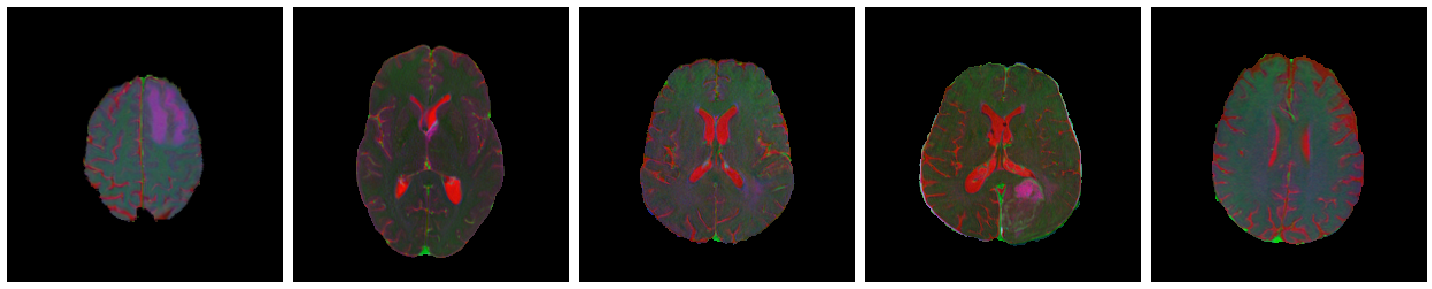

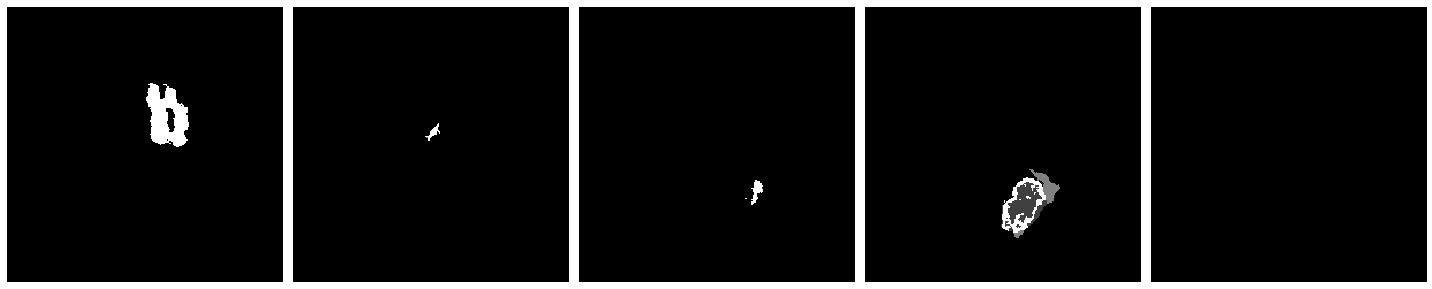

In [9]:
print(y[:5])
plots.plot_rgb_images(x[:5])
plots.plot_gray_images(x_seg[:5])

### Prepare analyzer

In [10]:
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

### Analyze

In [6]:
def input_postprocessing(X):
    return X

def postprocess(X):
    X = X.copy()
    X = iutils.postprocess_images(X)
    return X

def bk_proj(X):
    X = ivis.clip_quantile(X, 1)
    return ivis.project(X)


def heatmap(X):
    return ivis.heatmap(X)


def graymap(X):
    return ivis.graymap(np.abs(X), input_is_positive_only=True)

input_range = [0, 1]
noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]
methods = [
    # Function
    ("gradient",              {"postprocess": "abs"},   graymap,        "Gradient"),
    ("smoothgrad",            {}                       ,graymap,        "SmoothGrad"),
    # Signal
    ("deconvnet",             {},                       bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       bk_proj,        "Guided Backprop",),
    # Interaction
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, heatmap,        "DeepTaylor"),
    ("input_t_gradient",      {},                       heatmap,        "Input * Gradient"),
    ("integrated_gradients",  {"reference_inputs": ri}, heatmap,        "Integrated Gradients"),
    ("lrp.z",                 {},                       heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           heatmap,        "LRP-Epsilon"),
]

In [9]:
# Create analyzers.
analyzers = []
for method in methods:
    print(method[3])
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    analyzers.append(analyzer)

Gradient


NameError: name 'model_wo_softmax' is not defined

In [13]:
channels_first = keras.backend.image_data_format() == "channels_first"
color_conversion = None
def postprocess(X, color_conversion, channels_first):
    X = X.copy()
    X = iutils.postprocess_images(
        X, color_coding=color_conversion, channels_first=channels_first)
    return X


n = 5
val_images, val_labels = next(val_gen)
test_images = list(zip(val_images[:n], val_labels[:n]))
label_to_class_name = { 0: '0', 1: '1'}

text = []
analysis = np.zeros([len(test_images), len(analyzers), 240, 240, 3])

for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        a = analyzer.analyze(x)
        a = postprocess(a, color_conversion, channels_first)
        a = methods[aidx][2](a)
        img = a[0]
        analysis[i, aidx] = img


<Figure size 432x288 with 0 Axes>

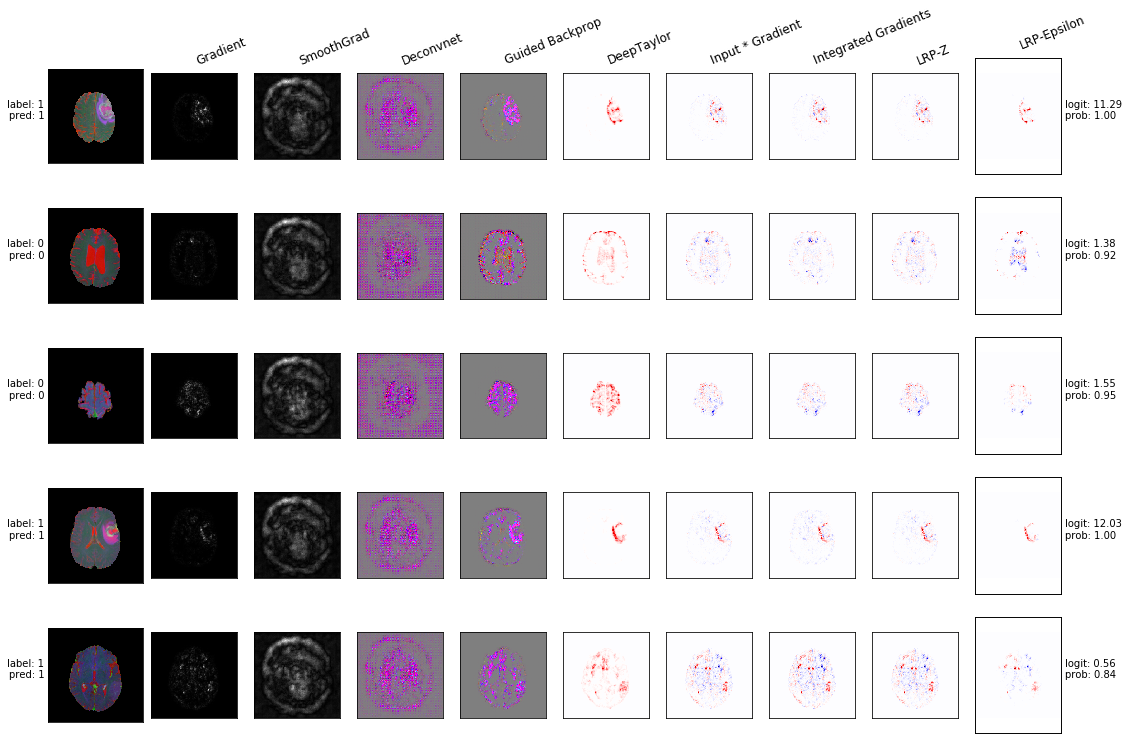

In [14]:
def get_label(l):
    return np.argmax(l)

# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# # Prepare the labels
label, presm, prob, pred = zip(*text)
# row_labels_left = [['label: {}'.format(l)] for l in val_labels[:n]]
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]
plots.plot_image_grid(val_images[:n],
                      grid,row_labels_left,
                      row_labels_right,
                      col_labels,figsize=(20,15))

# Evaluate interpretation

In [15]:
def image_and_mask_generator(gen, sgen, classes=None):
    return zip(get_generator(gen,classes=classes), get_seg_generator(sgen,classes=classes))
 
generator = image_and_mask_generator(val_generator, seg_generator)

(x, y),(x_seg,y_seg) = next(generator)
n = 5
x, x_seg, y = x[:n], x_seg[:n], y[:n]

Found 3360 images belonging to 2 classes.
Found 3360 images belonging to 2 classes.


## Comparission of methods
 
We will show interpretation of neural network prediction and than we will evaluate quantitative measurements of tests.

### Gradient

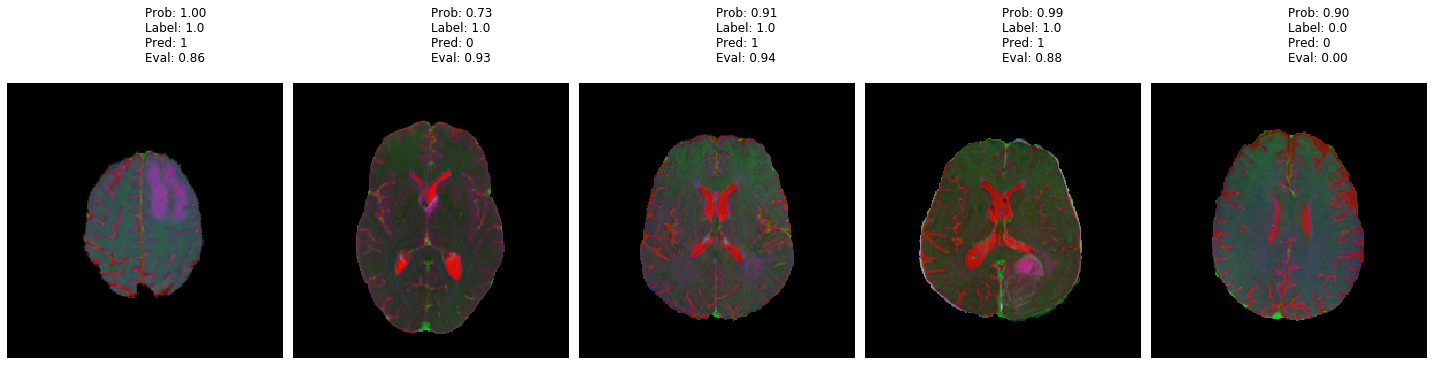

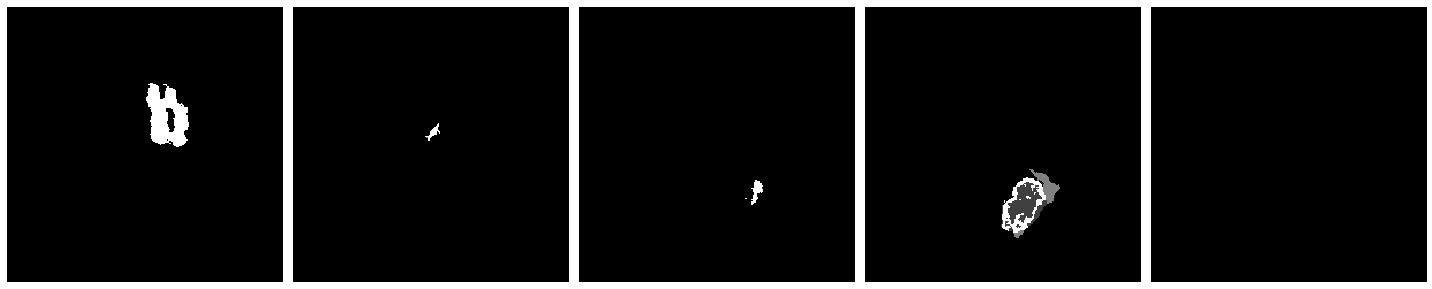

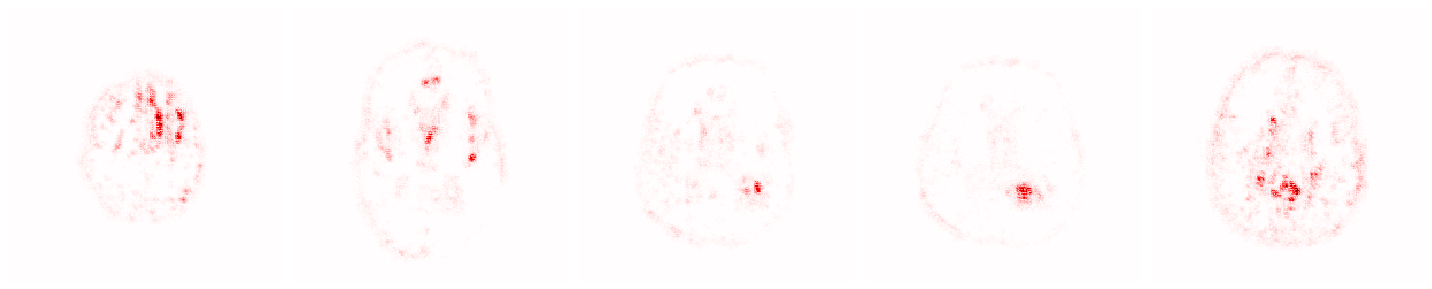

In [16]:
evaluation.evaluate_method_visualize(model, analyzers[0], x, x_seg, y)

In [78]:
seg_generator2 = ImageDataGenerator()
only_pos_gen = image_and_mask_generator(val_generator, seg_generator2, ["1"])

def get_results(eval_function, model, method, data_generator, num_data=2381):
    results = []
    num_epoch = num_data // batch_size

    for i, ((x,y),(x_seg,y_seg)) in enumerate(data_generator):
        arr = list(eval_function(model, method, x, x_seg, y))
        results = results + arr

        if i >= num_epoch:
                break
    return results
                
results = get_results(evaluation.evaluate_method, model, analyzers[0], only_pos_gen)

Found 2381 images belonging to 1 classes.
Found 2381 images belonging to 1 classes.


In [79]:
pred = np.array([r[1] for r in results])
val = np.array([r[2] for r in results])

##### Plot distribuion of true positive and false negative results

            data1    data2
mean:    |  0.74  |  0.80  |
std:     |  0.19  |  0.10  |
min:     |  0.16  |  0.27  |
max:     |  0.97  |  0.97  |
median:  |  0.80  |  0.83  |


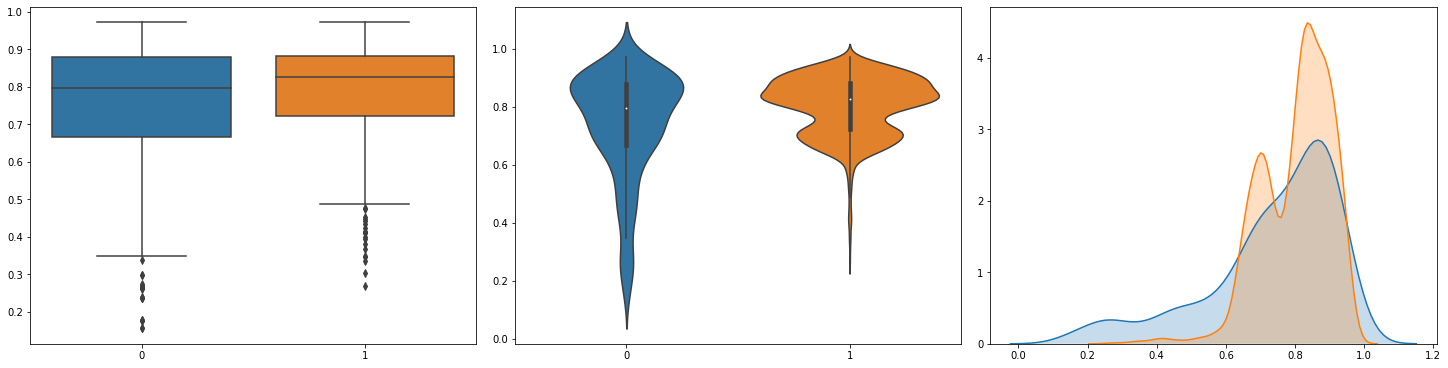

In [80]:
plots.plot_data_distribution(val[pred==0], val[pred==1])

H0: u1=u2, H1: u1!=u2

In [81]:
alpha = 0.05
stat, p = scipy.stats.ttest_ind(val[pred==0], val[pred==1])
p > alpha

False

There is statistical difference between true positive and false negative interpretations

### LRP-Z

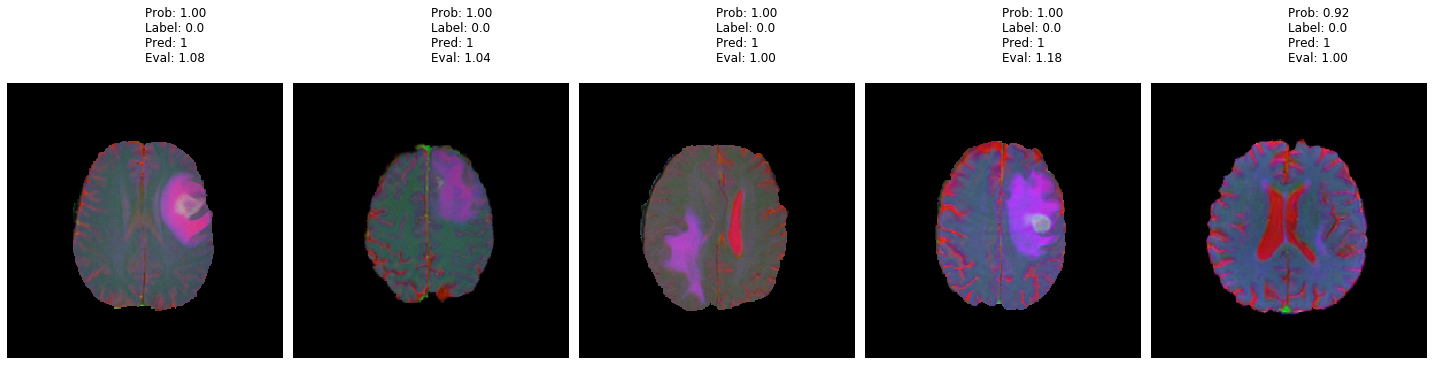

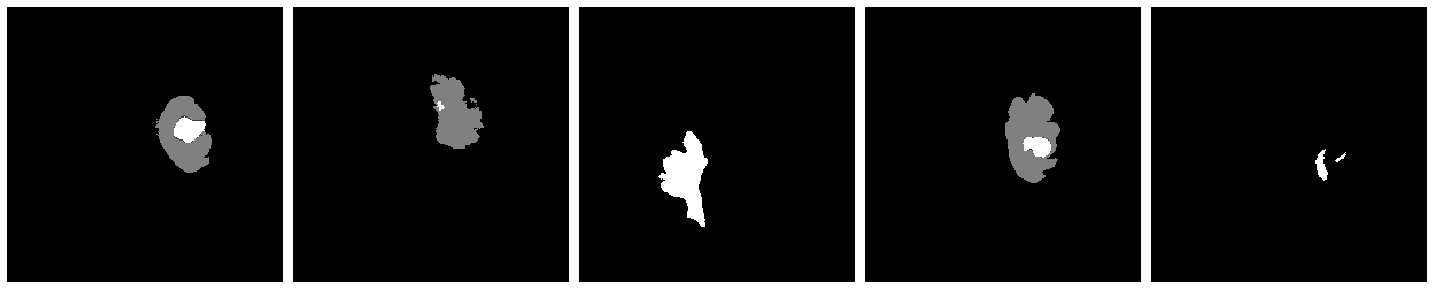

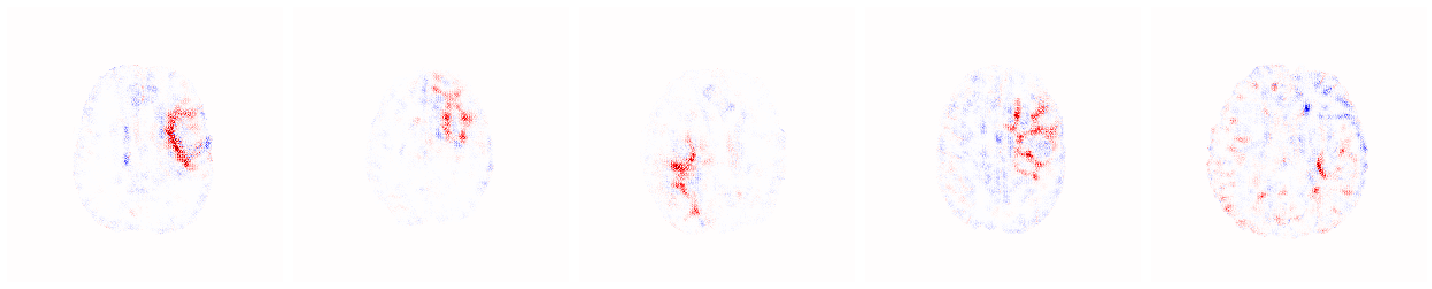

In [83]:
evaluation.evaluate_method_visualize(model, analyzers[7], x, x_seg, y)

#### Statistics

In [84]:
results = get_results(evaluation.evaluate_method,model, analyzers[7], only_pos_gen)
pred = np.array([r[1] for r in results])
val = np.array([r[2] for r in results])

            data1    data2
mean:    |  1.03  |  1.05  |
std:     |  0.44  |  0.08  |
min:     |  -0.89  |  0.72  |
max:     |  4.93  |  1.42  |
median:  |  1.01  |  1.03  |


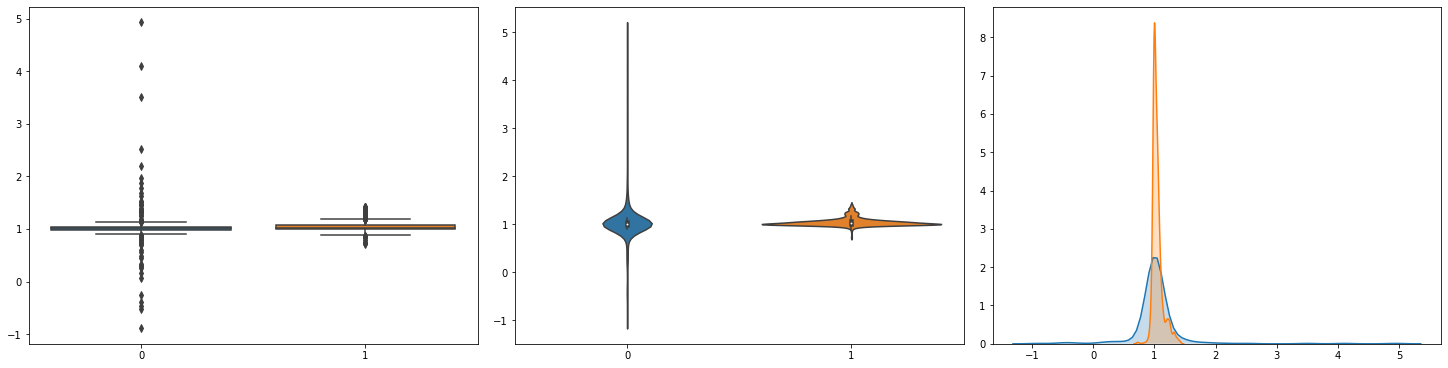

In [85]:
plots.plot_data_distribution(utils.reject_outliers(val[pred==0],1.5), utils.reject_outliers(val[pred==1],1.5))

In [86]:
alpha = 0.05
stat, p = scipy.stats.ttest_ind(val[pred==0], val[pred==1])
p > alpha

False

### LRP-epsilon

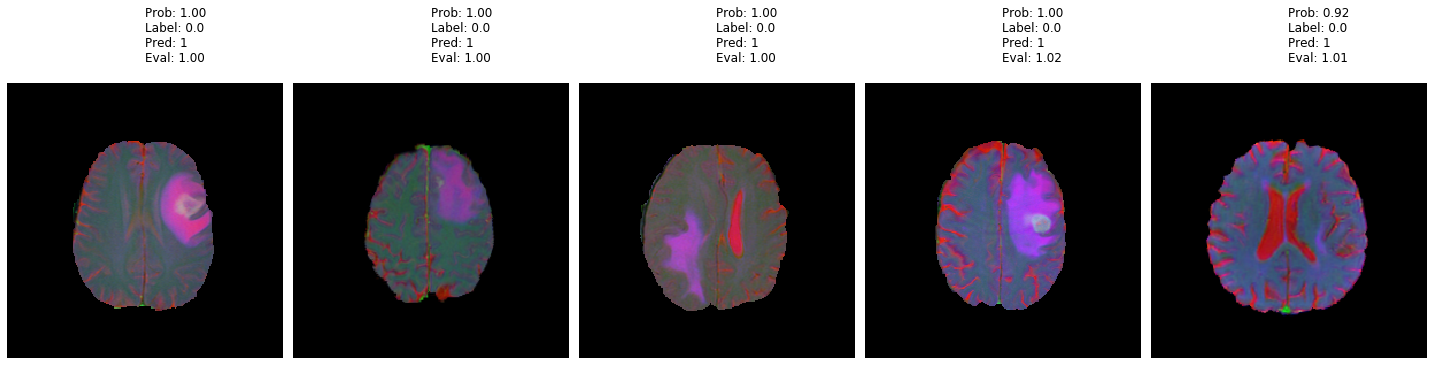

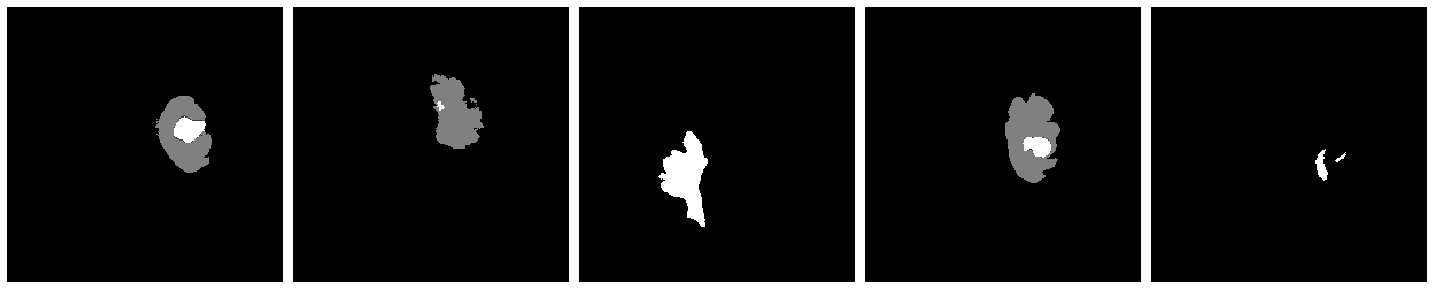

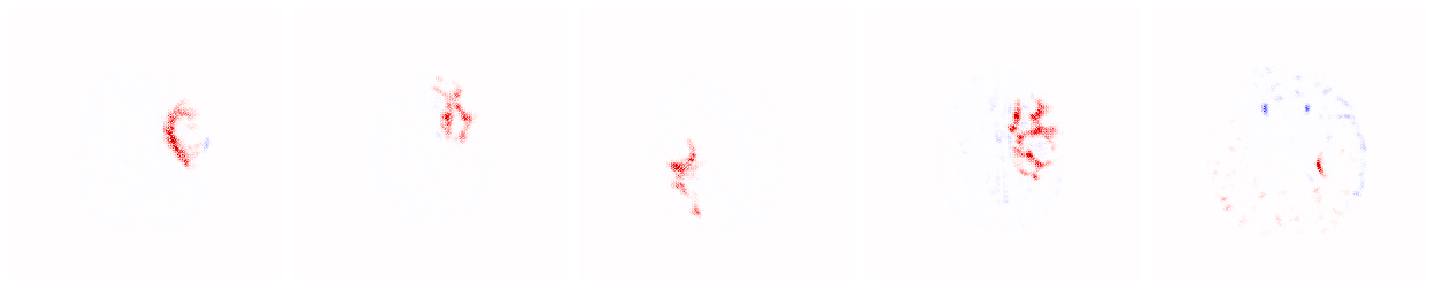

In [87]:
evaluation.evaluate_method_visualize(model, analyzers[8], x, x_seg, y)

In [88]:
results = get_results(evaluation.evaluate_method, model, analyzers[8], only_pos_gen)
pred = np.array([r[1] for r in results])
val = np.array([r[2] for r in results])

            data1    data2
mean:    |  0.83  |  0.99  |
std:     |  0.77  |  0.14  |
min:     |  -3.76  |  -1.04  |
max:     |  5.17  |  1.75  |
median:  |  1.00  |  1.00  |


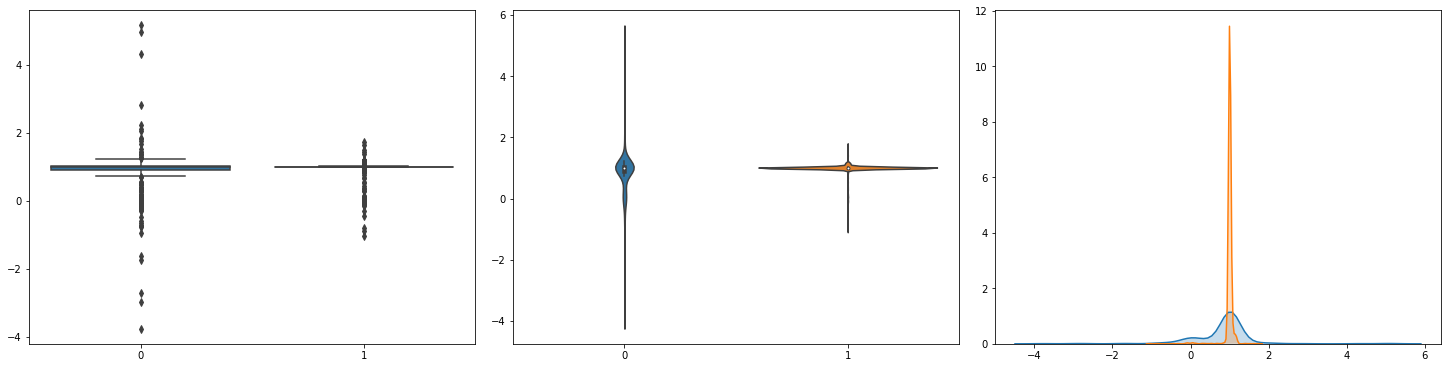

In [89]:
plots.plot_data_distribution(utils.reject_outliers(val[pred==0],1.5), utils.reject_outliers(val[pred==1],1.5))

In [90]:
alpha = 0.05
stat, p = scipy.stats.ttest_ind(val[pred==0], val[pred==1])
p > alpha

True

## Comparision of tumor regions

In [91]:
seg_generator2 = ImageDataGenerator()
only_pos_gen = image_and_mask_generator(val_generator, seg_generator2, ["1"])

Found 2381 images belonging to 1 classes.
Found 2381 images belonging to 1 classes.


In [92]:
(x,y),(x_seg,y_seg) = next(only_pos_gen)

### Gradient

Pred: 1, prob: 0.9295
1: 0.6726, 2: 0.5604, 3: 0.0000, 4: 0.5522, total: 0.6533


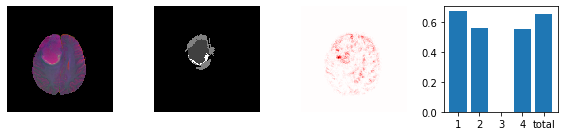

Pred: 1, prob: 0.9979
1: 0.8962, 2: 0.7790, 3: 0.0000, 4: 0.7713, total: 0.8456


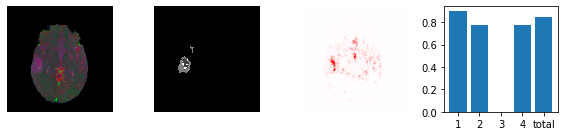

Pred: 1, prob: 0.6461
1: 0.8684, 2: 0.7672, 3: 0.0000, 4: 0.7281, total: 0.7682


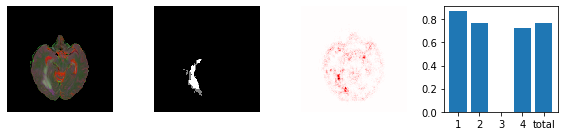

In [93]:
evaluation.evaluate_masks_visualize(model, analyzers[0], x[0], x_seg[0], y[0], figsize=(8,2))
evaluation.evaluate_masks_visualize(model, analyzers[0], x[1], x_seg[1], y[1], figsize=(8,2))
evaluation.evaluate_masks_visualize(model, analyzers[0], x[2], x_seg[2], y[2], figsize=(8,2))

In [95]:
results = get_results(evaluation.evaluate_masks, model, analyzers[0], only_pos_gen)

In [131]:
len(results)
y_hat = map(lambda x: x[1], results)
y_1 = list(filter(lambda x: x!=0, map(lambda x: x[2], results)))
y_2 = list(filter(lambda x: x!=0, map(lambda x: x[3], results)))
y_3 = list(filter(lambda x: x!=0, map(lambda x: x[4], results)))
y_4 = list(filter(lambda x: x!=0, map(lambda x: x[5], results)))
y_t = list(map(lambda x: x[6], results))
print(len(y_1))
print(len(y_2))
print(len(y_3))
print(len(y_4))

def values_for_class(cls, val, results, f=False):
    if f:
        return list(filter(lambda x: x!=0, map(lambda x: x[val], filter(lambda l: l[1]==cls, results))))
    else:
        return list(map(lambda x: x[val], filter(lambda l: l[1]==cls, results)))

1581
2363
0
1631


In [ ]:
values_for_class(1, 2, results, True)

#### Boxplot of tumors segmentation labels: 1, 2, 4, all

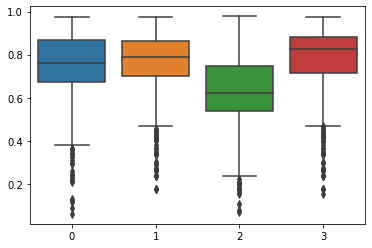

In [108]:
sns.boxplot(data=[list(y_1), list(y_2), list(y_4), list(y_t)])

#### Data distribution of tumor segmentations regions 

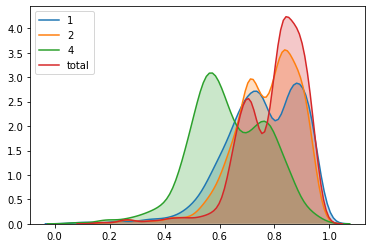

In [121]:
sns.kdeplot(data = y_1, shade=True, label='1')
sns.kdeplot(data = y_2, shade=True, label='2')
sns.kdeplot(data = y_4, shade=True, label='4')
sns.kdeplot(data = y_t, shade=True, label='total')

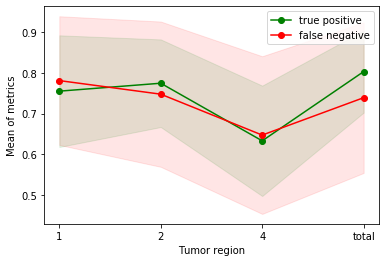

In [145]:
y1 = [values_for_class(1, 2, results, True), values_for_class(1, 3, results, True), values_for_class(1, 5, results, True), values_for_class(1, 6, results, True)]
y2 = [values_for_class(0, 2, results, True), values_for_class(0, 3, results, True), values_for_class(0, 5, results, True), values_for_class(0, 6, results, True)]
y_1_mean = np.array([np.mean(x) for x in y1])
y_2_mean = np.array([np.mean(x) for x in y2])
y_1_std = np.array([np.std(x) for x in y1])
y_2_std = np.array([np.std(x) for x in y2])

x = ['1','2','4','total']
plt.fill_between(x, y_2_mean - y_2_std, y_2_mean + y_2_std, alpha=0.1, color="r")
plt.fill_between(x, y_1_mean - y_1_std, y_1_mean + y_1_std, alpha=0.1, color="g")
plt.plot(x, y_1_mean, 'o-', label = "true positive", color="g")
plt.plot(x, y_2_mean, 'o-', label = "false negative", color="r")
plt.xlabel('Tumor region')
plt.ylabel('Mean of metrics')
plt.legend()
plt.show()

## Statistic evaluation of interpretation methods

In [146]:
generator = image_and_mask_generator(val_generator, seg_generator)

Found 3360 images belonging to 2 classes.
Found 3360 images belonging to 2 classes.


In [149]:
num_data=3360
results = []
num_epoch = num_data // batch_size

for i, ((x,y),(x_seg,y_seg)) in enumerate(generator):
    arr = [(y, np.argmax(p), np.mean(a[utils.get_mask_of_brain_rgb(i)]), np.std(a[utils.get_mask_of_brain_rgb(i)])) 
           for i,a,p,y in zip(x,method.analyze(x),model.predict_on_batch(x),y)]
    results = results + arr

    if i >= num_epoch:
            break

In [155]:
tp = list(map(lambda x: (x[2], x[3]), filter(lambda x: x[0]==1 and x[1]==1, results)))
tn = list(map(lambda x: (x[2], x[3]), filter(lambda x: x[0]==0 and x[1]==0, results)))
fp = list(map(lambda x: (x[2], x[3]), filter(lambda x: x[0]==0 and x[1]==1, results)))
fn = list(map(lambda x: (x[2], x[3]), filter(lambda x: x[0]==1 and x[1]==0, results)))

In [157]:
print("tp: ",len(tp))
print("tn: ",len(tn))
print("fp: ",len(fp))
print("fn: ",len(fn))

tp:  2086
tn:  767
fp:  216
fn:  307


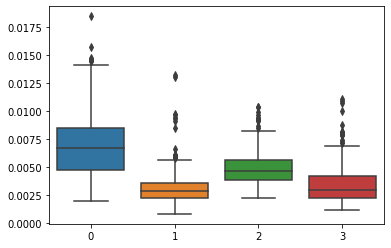

In [166]:
sns.boxplot(data=[[x[0] for x in tp], [x[0] for x in tn], [x[0] for x in fp], [x[0] for x in fn]])

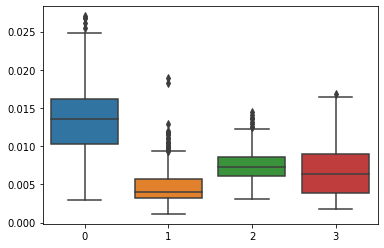

In [162]:
sns.boxplot(data=[[x[1] for x in tp], [x[1] for x in tn], [x[1] for x in fp], [x[1] for x in fn]])

### MRI modalities 

In [23]:
def evaluate_mri(analyzer, model,  image, mask):
    image = image[None, :, :, :]
    mask_t = utils.get_mask_of_seg_rgb(mask)
    pred = model.predict(image)
    prob = pred.max()
    pred = pred.argmax()
    
    a = analyzer.analyze(image)
    vt = evaluation.mask_value(a[0], image[0], mask_t)
    
    plots.plot_rgb_decomposition(image[0])
    plots.plot_rgb_decomposition(mask_t)
    plots.plot_rgb_decomposition(a[0],'seismic', (-1, 1))

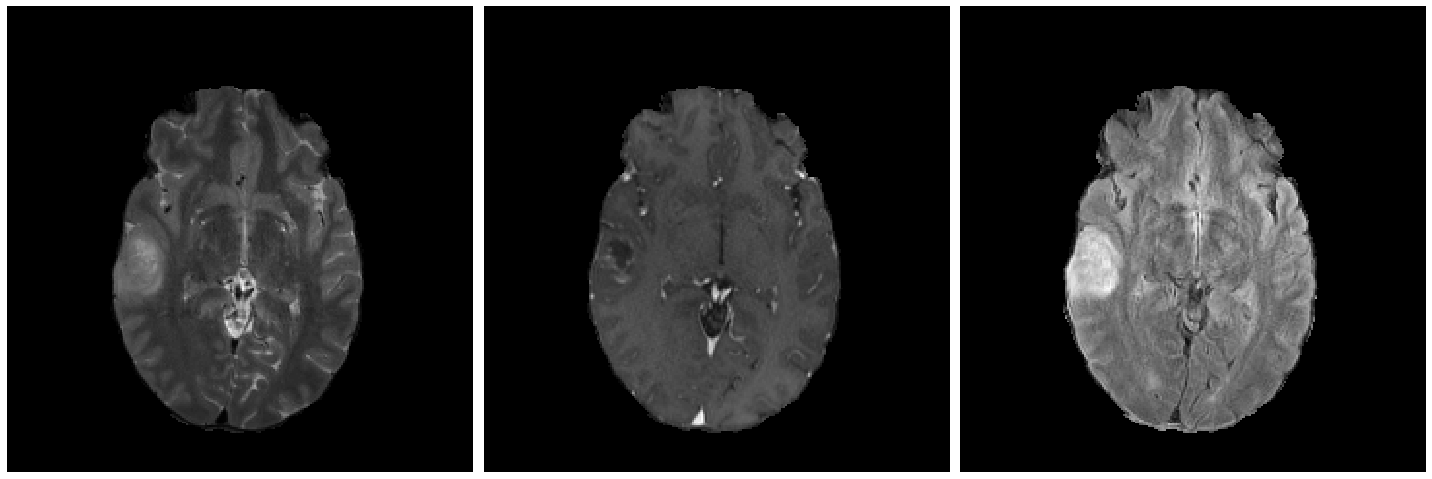

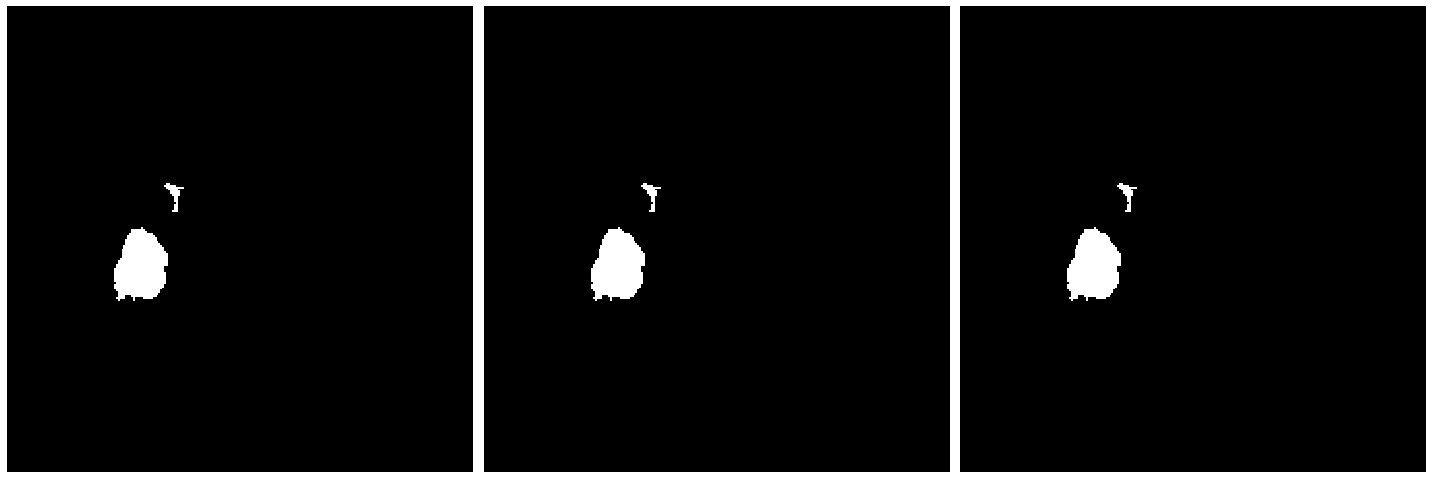

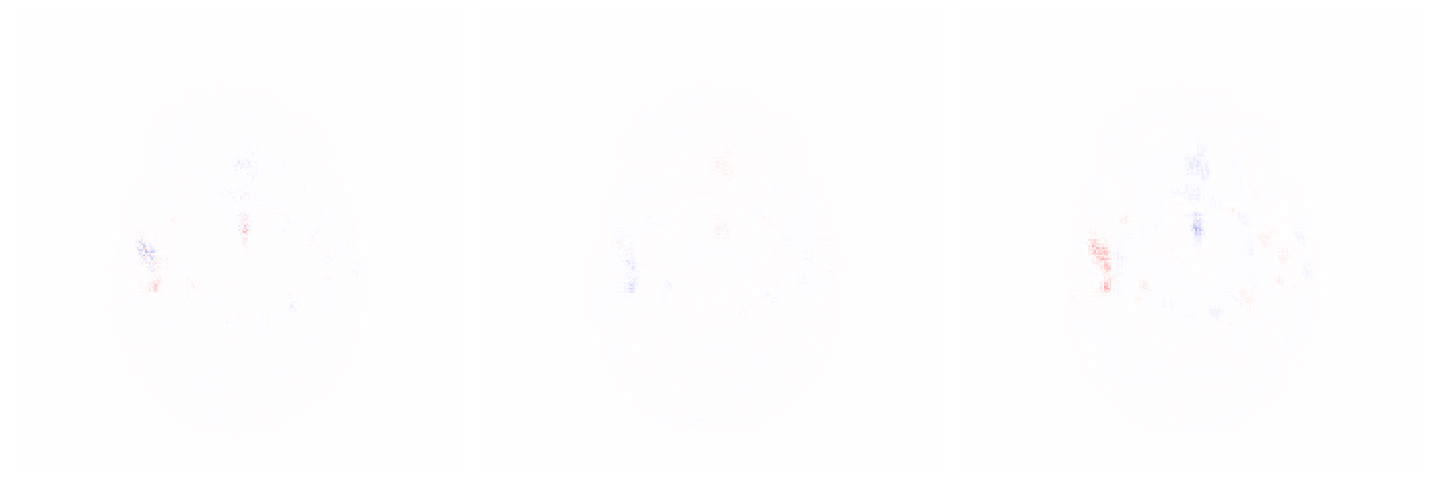

In [24]:
evaluate_mri(analyzers[7],model,x[1],x_seg[1])